In [123]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import datetime
import glob
import os


ceiling = 6000
floor = 1
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2023, 12, 31)

# Format https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd
columns = ["price", "date","postcode", "type", "new", "duration","category"]
files = ["RG30","RG31"]
df_raw = pd.concat(
    (pd.read_csv(f"./{file}.csv", names=columns, usecols=[1,2,3,4,5,6,14], header=None).assign(source=file) for file in files), 
    ignore_index=True
)
df_raw.date = pd.to_datetime(df_raw.date, errors='coerce')
df_raw.price = pd.to_numeric(df_raw.price).div(1000).astype(int)

print(df_raw.head(10))

   price       date  postcode type new duration category source
0     46 1995-11-10  RG30 2BY    F   N        L        A   RG30
1     55 1995-03-17  RG30 6DT    S   N        F        A   RG30
2     79 1995-11-30  RG30 2BU    T   N        F        A   RG30
3     52 1995-02-13  RG30 2UY    T   N        F        A   RG30
4     48 1995-07-07  RG30 2UL    T   N        F        A   RG30
5     38 1995-05-12  RG30 2RB    T   N        F        A   RG30
6     78 1995-10-16  RG30 3HG    D   N        F        A   RG30
7     68 1995-04-12  RG30 6HX    S   N        F        A   RG30
8     69 1995-09-08  RG30 2ET    F   Y        L        A   RG30
9     33 1995-06-21  RG30 2TH    T   N        F        A   RG30


In [141]:
df = df_raw
df = df[(df.price < ceiling) & (df.price > floor)]
df = df[(df.date > start) & (df.date < end)]
df = df[(df.category == "A")] # Standard Price Paid entry, includes single residential property sold for value.
df = df[(df.duration == "F")] # Freehold
#df = df[(df.type == "S")] # Semi-detached
df = df[(df.type == "D")] # Semi-detached
#df = df[(df.type == "D") | (df.type == "S")] # Semi-detached

df = df.sort_values(by=['date'])
df.set_index('date', inplace=True)

df30 = df[(df.source == "RG30")]
df31 = df[(df.source == "RG31")]
print(df30.head(10))

            price  postcode type new duration category source
date                                                         
2006-01-04    167  RG30 4HY    D   N        F        A   RG30
2006-01-20    317  RG30 3TJ    D   N        F        A   RG30
2006-01-23    450  RG30 1DY    D   N        F        A   RG30
2006-01-23    249  RG30 2SF    D   N        F        A   RG30
2006-01-27    232  RG30 2NG    D   N        F        A   RG30
2006-02-23    294  RG30 4RX    D   N        F        A   RG30
2006-02-24    323  RG30 2PX    D   N        F        A   RG30
2006-03-08    144  RG30 4XL    D   N        F        A   RG30
2006-03-09    484  RG30 2AL    D   N        F        A   RG30
2006-03-24    155  RG30 2QJ    D   N        F        A   RG30


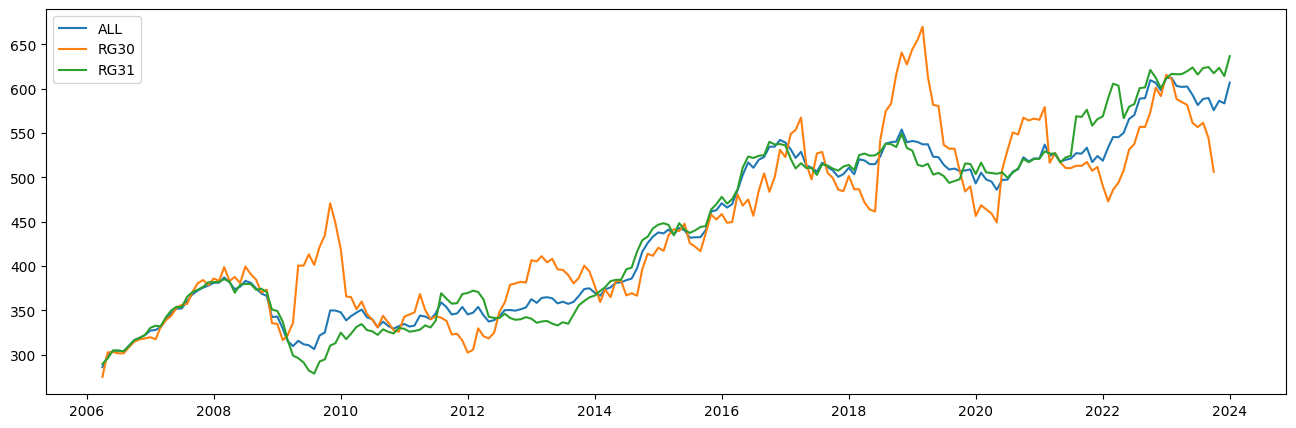

In [143]:
dfs = {
    "ALL" : df,
    "RG30": df30,
    "RG31": df31
}

for key, data in dfs.items():
    #plt.plot(data.price.rolling(window=50, min_periods=10, win_type='gaussian').mean(std=1000), label=key)
    plt.plot(data.price.resample("ME").mean().rolling(window=9, min_periods=3).mean(), label=key)
    #plt.plot(data.price, label=key)

plt.gca().xaxis.set_major_locator(YearLocator(2))
plt.legend()
plt.rcParams["figure.figsize"] = (16, 5)
plt.show()

In [144]:
price_to_average_when_bought = 350/230 # 2008-06
print(price_to_average_when_bought)
weighted_price_now = price_to_average_when_bought * 370
print(weighted_price_now)

1.5217391304347827
563.0434782608696


In [145]:
monthly_counts = df.resample('ME').size()
monthly_counts_30 = df30.resample('ME').size()
monthly_counts_31 = df31.resample('ME').size()
print(monthly_counts.tail(36))

date
2021-01-31    26
2021-02-28    20
2021-03-31    32
2021-04-30     9
2021-05-31    11
2021-06-30    37
2021-07-31     6
2021-08-31     8
2021-09-30    23
2021-10-31     6
2021-11-30    17
2021-12-31     9
2022-01-31     6
2022-02-28    10
2022-03-31    14
2022-04-30    10
2022-05-31    15
2022-06-30    16
2022-07-31    17
2022-08-31    17
2022-09-30    17
2022-10-31     8
2022-11-30    12
2022-12-31    14
2023-01-31    13
2023-02-28    13
2023-03-31     9
2023-04-30    11
2023-05-31     8
2023-06-30     5
2023-07-31    13
2023-08-31    14
2023-09-30    13
2023-10-31     2
2023-11-30     3
2023-12-31     1
Freq: ME, dtype: int64


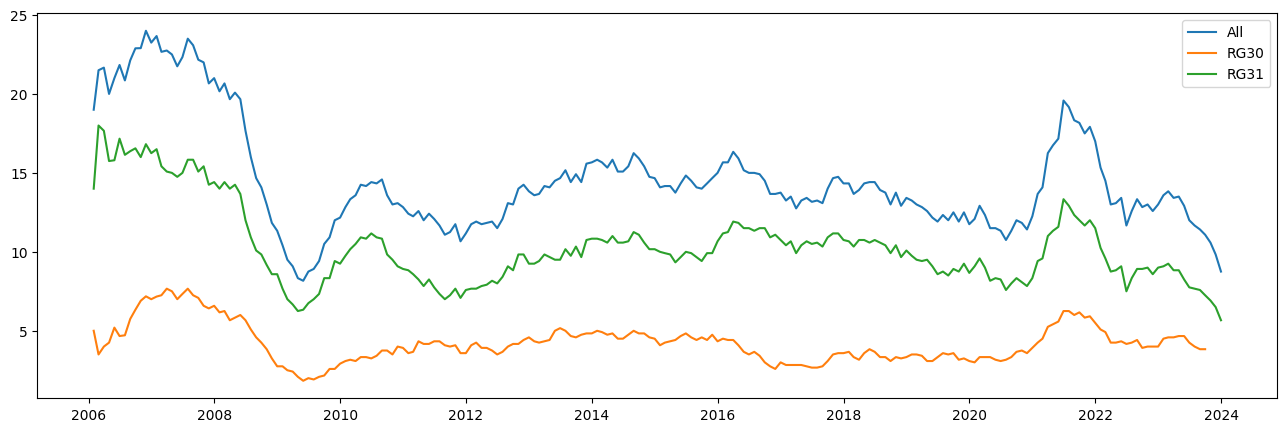

In [130]:
plt.plot(monthly_counts.rolling(window=12, min_periods=1).mean(), label="All")
plt.plot(monthly_counts_30.rolling(window=12, min_periods=1).mean(), label="RG30")
plt.plot(monthly_counts_31.rolling(window=12, min_periods=1).mean(), label="RG31")
plt.gca().xaxis.set_major_locator(YearLocator(2))
plt.legend()
plt.show()